In [1]:
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from albumentations.pytorch import ToTensorV2


In [2]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
#  To get unique colors in RGB masked image

l=[]

for i in range(4864):
       for j in range(20480):
            for s in list(img[i][j]):
              if s not in l:
                l.append(s)
"""

'\n#  To get unique colors in RGB masked image\n\nl=[]\n\nfor i in range(4864):\n       for j in range(20480):\n            for s in list(img[i][j]):\n              if s not in l:\n                l.append(s)\n'

In [3]:
COLORMAP = [
        [0, 0, 0],
        [255, 255, 0],
        [150, 150, 150],
        [0, 255, 0],
        [0, 0, 255],
        [0, 150, 255] 
    ]

CLASSES = [
        'background',
        'yellow',
        'grey',
        'green',
        'blue',
        'red'
    ]


In [ ]:
def set_seed(seed = 0):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
set_seed()

In [ ]:
#train_transform = A.Compose([
#    #A.Resize(width=128, height=128, p=1.0),
#    A.HorizontalFlip(p=0.5),
#    A.VerticalFlip(p=0.5),
#    A.RandomRotate90(p=0.5),
#    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
#])

In [12]:
class BiopseDataset(data.Dataset):
    """ Dataset class for Biopse Dataset """
    def __init__(self, dir_path, colormap, transform=None):
        self.dir_path = dir_path
        self.transforms = transform
        self.img_dir=os.path.join(dir_path,"images")
        self.mask_dir=os.path.join(dir_path,"masks")
        self.images=os.listdir(self.img_dir)
        self.masks=os.listdir(self.mask_dir)
        self.colormap=colormap

    def process_mask(self, rgb_mask):
         output_mask = []
         for i, color in enumerate(self.colormap):
             cmap = np.all(np.equal(rgb_mask, color), axis=-1)
             #print(np.equal(rgb_mask, color).shape)

             output_mask.append(cmap)
         #print(len(output_mask))
         output_mask = np.argmax(output_mask, axis=0)
         #print(output_mask.shape)
         
         #print(np.unique(output_mask))
         #print(output_mask)

         return output_mask

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,index):
        img = np.array(Image.open(os.path.join(self.img_dir,self.images[index])))
        img=img/255.0
        mask = np.array(Image.open(os.path.join(self.mask_dir,self.masks[index])))
        if self.transforms is not None:
            mask = self.process_mask(mask)
            aug = self.transforms(image=img,mask=mask)
            img = aug['image']
            mask = aug['mask']
            #mask = self.process_mask(mask) #torch.max(mask,dim=2)[0]
        return img,mask

In [4]:
t1 = A.Compose([
    #A.Resize(160,240),
    #A.augmentations.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

In [ ]:
def get_images(image_dir,transform = None,batch_size=1,shuffle=True,pin_memory=True):
    data = BiopseDataset(image_dir,COLORMAP,transform = transform)
    train_size = int(0.8 * data.__len__())  # keeping train/test ratio 80%/20%
    test_size = data.__len__() - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])
    train_batch = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory) # train dataloader
    test_batch = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory) # test dataloader
    return train_batch,test_batch

In [ ]:
train_batch,test_batch = get_images("/content/drive/MyDrive/biopsedata",transform =t1,batch_size=4)


In [ ]:
#for img,mask in train_batch:
#    mask1 = np.array(mask[0,:,:])
#    print(np.unique(mask1))
#    print(mask1.shape)

torch.float64


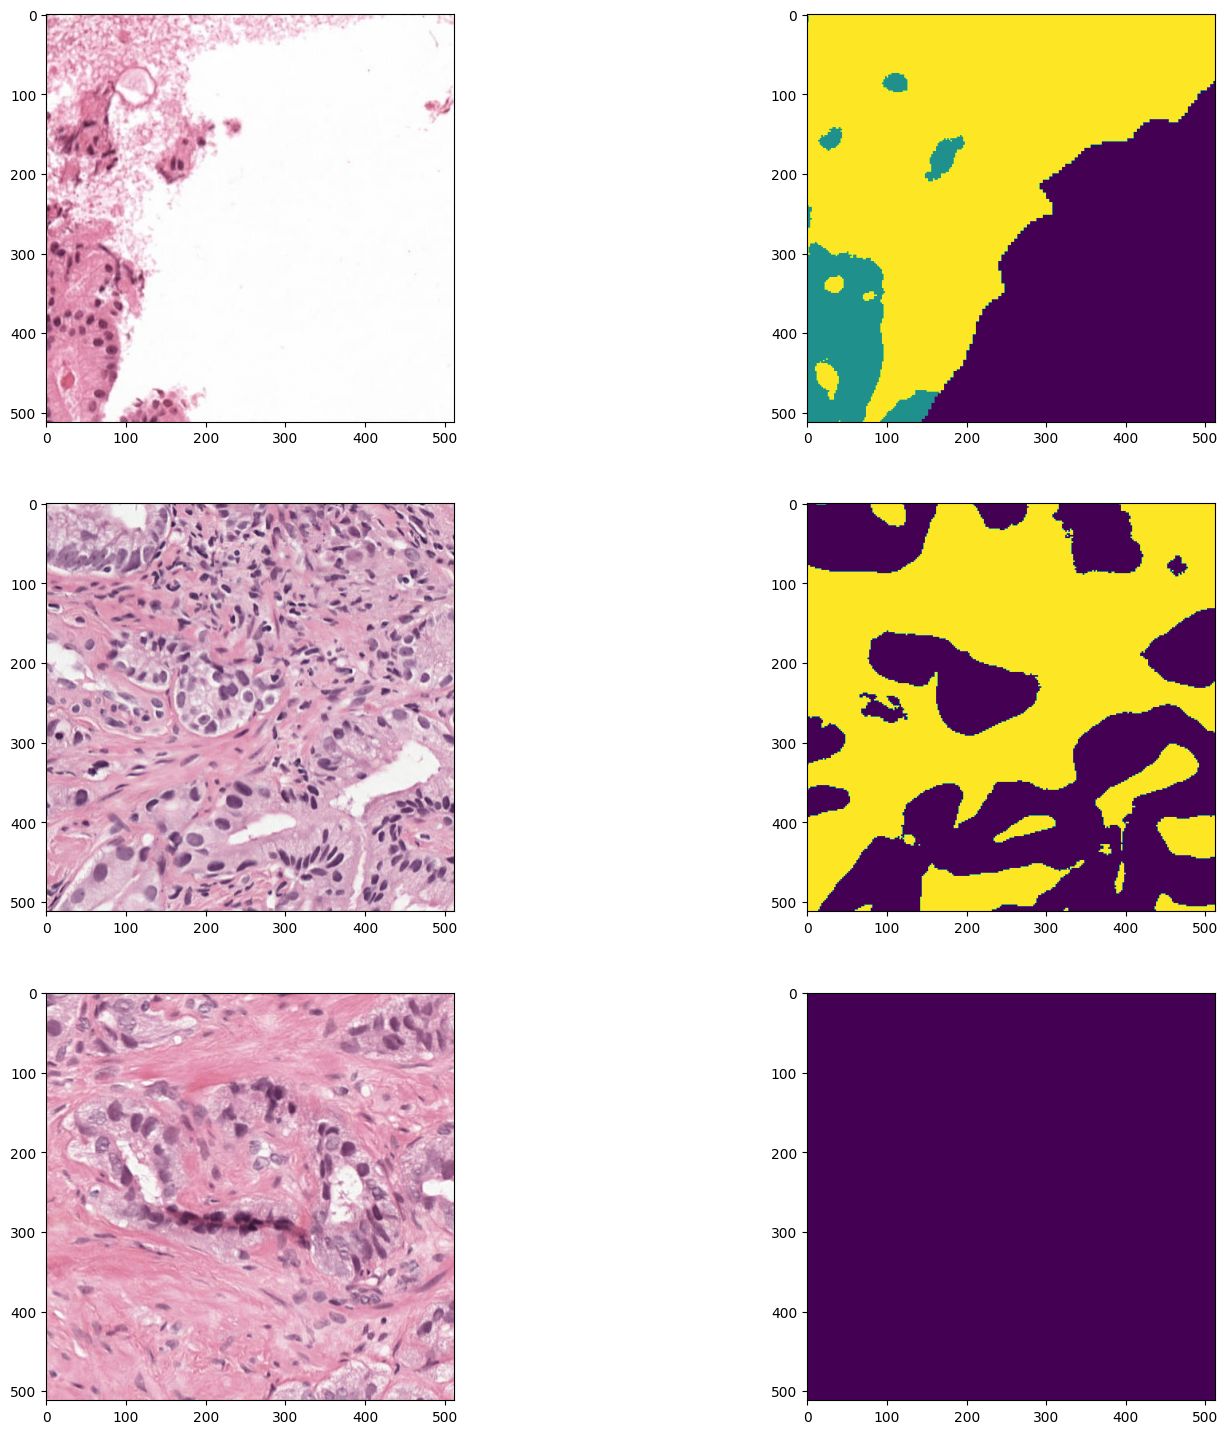

In [ ]:
for img,mask in train_batch:
    print(img[0].dtype)
    img1 = np.transpose(img[0,:,:,:],(1,2,0))
    mask1 = np.array(mask[0,:,:])
    img2 = np.transpose(img[1,:,:,:],(1,2,0))
    mask2 = np.array(mask[1,:,:])
    img3 = np.transpose(img[2,:,:,:],(1,2,0))
    mask3 = np.array(mask[2,:,:])
    fig , ax =  plt.subplots(3, 2, figsize=(18, 18))
    ax[0][0].imshow(img1)
    ax[0][1].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(mask3)
    break

In [ ]:
!pip install torchsummary 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
class encoding_block(nn.Module):
    def __init__(self,in_channels, out_channels):
        super(encoding_block,self).__init__()
        model = []
        model.append(nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        model.append(nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False))
        model.append(nn.BatchNorm2d(out_channels))
        model.append(nn.ReLU(inplace=True))
        self.conv = nn.Sequential(*model)
    def forward(self, x):
        return self.conv(x)    

In [7]:
class unet_model(nn.Module):
    def __init__(self,out_channels=6,features=[64, 128, 256, 512]):
        super(unet_model,self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
        self.conv1 = encoding_block(3,features[0])
        self.conv2 = encoding_block(features[0],features[1])
        self.conv3 = encoding_block(features[1],features[2])
        self.conv4 = encoding_block(features[2],features[3])
        self.conv5 = encoding_block(features[3]*2,features[3])
        self.conv6 = encoding_block(features[3],features[2])
        self.conv7 = encoding_block(features[2],features[1])
        self.conv8 = encoding_block(features[1],features[0])        
        self.tconv1 = nn.ConvTranspose2d(features[-1]*2, features[-1], kernel_size=2, stride=2)
        self.tconv2 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
        self.tconv3 = nn.ConvTranspose2d(features[-2], features[-3], kernel_size=2, stride=2)
        self.tconv4 = nn.ConvTranspose2d(features[-3], features[-4], kernel_size=2, stride=2)        
        self.bottleneck = encoding_block(features[3],features[3]*2)
        self.final_layer = nn.Conv2d(features[0],out_channels,kernel_size=1)
    def forward(self,x):
        skip_connections = []
        x = self.conv1(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv2(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv3(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.conv4(x)
        skip_connections.append(x)
        x = self.pool(x)
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]
        x = self.tconv1(x)
        x = torch.cat((skip_connections[0], x), dim=1)
        x = self.conv5(x)
        x = self.tconv2(x)
        x = torch.cat((skip_connections[1], x), dim=1)
        x = self.conv6(x)
        x = self.tconv3(x)
        x = torch.cat((skip_connections[2], x), dim=1)
        x = self.conv7(x)        
        x = self.tconv4(x)
        x = torch.cat((skip_connections[3], x), dim=1)
        x = self.conv8(x)
        x = self.final_layer(x)
        return x

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
model = unet_model().to(DEVICE)


In [ ]:
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,864
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
    encoding_block-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,728
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,456
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [ ]:
LEARNING_RATE = 1e-4
num_epochs = 30

In [ ]:
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("logs")


In [ ]:
def compute_val_loss(test_batch, model):
    model.eval()
    for batch_idx, (data, targets) in enumerate(test_batch):
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data.float())
            loss = loss_fn(predictions, targets)
    model.train()
    return loss


In [ ]:
min_loss=10000
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_batch),total=len(train_batch))
    for batch_idx, (data, targets) in loop:
        #print(data.shape)
        #print(data[0])
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)
        targets = targets.type(torch.long)
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data.float())
            loss = loss_fn(predictions, targets)
        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        if batch_idx % 50 == 0:
              val_loss=compute_val_loss(test_batch, model)
              print ("Train loss"+ str(loss.item())+ " Val loss :"+ 
                     str(val_loss.item()))
              writer.add_scalar("train loss", epoch, loss.item())
              writer.add_scalar("validation loss", epoch, val_loss.item())
        loop.set_postfix(loss=loss.item())
        
    


    if loss < min_loss:
        min_loss=loss
        print("saving min loss at epoch"+ str(epoch))
        torch.save(model, "/content/drive/MyDrive/biopseModel.pth")
writer.close()


  1%|          | 1/162 [00:58<2:36:12, 58.22s/it, loss=1.78]

Train loss1.7845349311828613 Val loss :1.719956874847412


 31%|███▏      | 51/162 [02:27<09:57,  5.38s/it, loss=1.53]

Train loss1.5257837772369385 Val loss :1.100274682044983


 62%|██████▏   | 101/162 [03:58<05:37,  5.53s/it, loss=0.887]

Train loss0.8871234655380249 Val loss :0.9134485721588135


 93%|█████████▎| 151/162 [05:29<00:59,  5.45s/it, loss=0.78]

Train loss0.7798964977264404 Val loss :1.144277811050415


100%|██████████| 162/162 [05:45<00:00,  2.13s/it, loss=0.813]


saving min loss at epoch0


  1%|          | 1/162 [00:13<36:57, 13.78s/it, loss=0.982]

Train loss0.9820108413696289 Val loss :0.78176349401474


 31%|███▏      | 51/162 [01:02<08:27,  4.57s/it, loss=1.08]

Train loss1.075740098953247 Val loss :0.6839146018028259


 62%|██████▏   | 101/162 [01:50<04:31,  4.45s/it, loss=1.01]

Train loss1.011283278465271 Val loss :0.8004733920097351


 93%|█████████▎| 151/162 [02:39<00:49,  4.49s/it, loss=0.973]

Train loss0.9727939367294312 Val loss :0.8259296417236328


  1%|          | 1/162 [00:13<35:07, 13.09s/it, loss=0.614]

Train loss0.6142410039901733 Val loss :1.0134313106536865


 31%|███▏      | 51/162 [01:01<08:15,  4.46s/it, loss=0.69]

Train loss0.6895426511764526 Val loss :0.44164496660232544


 62%|██████▏   | 101/162 [01:49<04:33,  4.49s/it, loss=0.593]

Train loss0.5931469798088074 Val loss :0.6677176356315613


 93%|█████████▎| 151/162 [02:38<00:49,  4.46s/it, loss=0.554]

Train loss0.5544999241828918 Val loss :0.35124316811561584


  1%|          | 1/162 [00:13<35:39, 13.29s/it, loss=0.75]

Train loss0.7496482729911804 Val loss :1.4920704364776611


 31%|███▏      | 51/162 [01:01<08:25,  4.55s/it, loss=0.931]

Train loss0.931392252445221 Val loss :0.7363216876983643


 62%|██████▏   | 101/162 [01:50<04:33,  4.49s/it, loss=0.747]

Train loss0.7474887371063232 Val loss :0.5679226517677307


 93%|█████████▎| 151/162 [02:38<00:48,  4.42s/it, loss=0.652]

Train loss0.6522900462150574 Val loss :0.6049953699111938


100%|██████████| 162/162 [02:46<00:00,  1.03s/it, loss=0.666]


saving min loss at epoch3


  1%|          | 1/162 [00:13<36:54, 13.75s/it, loss=1.18]

Train loss1.18149733543396 Val loss :0.9074726104736328


 31%|███▏      | 51/162 [01:02<08:17,  4.48s/it, loss=0.459]

Train loss0.45875442028045654 Val loss :1.927293062210083


 62%|██████▏   | 101/162 [01:50<04:34,  4.49s/it, loss=0.608]

Train loss0.6077061891555786 Val loss :1.0259301662445068


 93%|█████████▎| 151/162 [02:39<00:49,  4.50s/it, loss=0.732]

Train loss0.7321339845657349 Val loss :0.8558694124221802


100%|██████████| 162/162 [02:46<00:00,  1.03s/it, loss=0.594]


saving min loss at epoch4


  1%|          | 1/162 [00:13<36:43, 13.69s/it, loss=0.57]

Train loss0.5703610777854919 Val loss :0.46840864419937134


 31%|███▏      | 51/162 [01:02<08:16,  4.47s/it, loss=1.05]

Train loss1.0516955852508545 Val loss :0.4897087812423706


 62%|██████▏   | 101/162 [01:50<04:33,  4.48s/it, loss=0.595]

Train loss0.5947595834732056 Val loss :0.6259138584136963


 93%|█████████▎| 151/162 [02:39<00:49,  4.50s/it, loss=0.912]

Train loss0.9116367101669312 Val loss :0.5831181406974792


100%|██████████| 162/162 [02:46<00:00,  1.03s/it, loss=0.338]


saving min loss at epoch5


  1%|          | 1/162 [00:13<36:39, 13.66s/it, loss=0.861]

Train loss0.8613066673278809 Val loss :0.9816241264343262


 31%|███▏      | 51/162 [01:01<08:09,  4.41s/it, loss=0.632]

Train loss0.632212221622467 Val loss :0.22048407793045044


 62%|██████▏   | 101/162 [01:49<04:30,  4.44s/it, loss=0.467]

Train loss0.46732479333877563 Val loss :1.5848956108093262


 93%|█████████▎| 151/162 [02:37<00:48,  4.45s/it, loss=1.05]

Train loss1.0463893413543701 Val loss :0.6194798350334167


  1%|          | 1/162 [00:13<35:19, 13.16s/it, loss=0.646]

Train loss0.6460542678833008 Val loss :0.6601039171218872


 31%|███▏      | 51/162 [01:00<07:56,  4.29s/it, loss=0.917]

Train loss0.9172483682632446 Val loss :0.6560351848602295


 62%|██████▏   | 101/162 [01:48<04:31,  4.45s/it, loss=0.928]

Train loss0.9282171726226807 Val loss :0.4306322932243347


 93%|█████████▎| 151/162 [02:37<00:48,  4.42s/it, loss=0.473]

Train loss0.47269928455352783 Val loss :0.23161154985427856


  1%|          | 1/162 [00:13<36:01, 13.43s/it, loss=0.447]

Train loss0.4465772807598114 Val loss :0.5005742907524109


 31%|███▏      | 51/162 [01:02<08:20,  4.51s/it, loss=0.785]

Train loss0.7847729921340942 Val loss :0.5877804160118103


 62%|██████▏   | 101/162 [01:50<04:29,  4.42s/it, loss=0.435]

Train loss0.43535852432250977 Val loss :0.6348615884780884


 93%|█████████▎| 151/162 [02:38<00:49,  4.50s/it, loss=1.2]

Train loss1.204172134399414 Val loss :0.706841766834259


  1%|          | 1/162 [00:13<34:56, 13.02s/it, loss=0.803]

Train loss0.8028045892715454 Val loss :0.14945802092552185


 31%|███▏      | 51/162 [01:01<08:13,  4.45s/it, loss=0.494]

Train loss0.4944261610507965 Val loss :0.43827250599861145


 62%|██████▏   | 101/162 [01:49<04:26,  4.36s/it, loss=0.685]

Train loss0.6852036118507385 Val loss :0.32024288177490234


 93%|█████████▎| 151/162 [02:37<00:48,  4.42s/it, loss=0.881]

Train loss0.8807474970817566 Val loss :0.24714675545692444


100%|██████████| 162/162 [02:45<00:00,  1.02s/it, loss=0.318]


saving min loss at epoch9


  1%|          | 1/162 [00:13<35:45, 13.33s/it, loss=0.474]

Train loss0.47427159547805786 Val loss :0.22282402217388153


 31%|███▏      | 51/162 [01:01<08:18,  4.50s/it, loss=0.822]

Train loss0.822390615940094 Val loss :0.25464776158332825


 62%|██████▏   | 101/162 [01:49<04:29,  4.42s/it, loss=1.02]

Train loss1.0215667486190796 Val loss :0.44852614402770996


 93%|█████████▎| 151/162 [02:37<00:48,  4.44s/it, loss=0.708]

Train loss0.7077562808990479 Val loss :0.6707757711410522


  1%|          | 1/162 [00:13<34:57, 13.03s/it, loss=0.86]

Train loss0.8597493767738342 Val loss :0.5459474325180054


 31%|███▏      | 51/162 [01:00<08:12,  4.44s/it, loss=0.499]

Train loss0.49894386529922485 Val loss :0.4213229715824127


 62%|██████▏   | 101/162 [01:49<04:32,  4.47s/it, loss=0.848]

Train loss0.8483555316925049 Val loss :0.5367207527160645


 93%|█████████▎| 151/162 [02:37<00:47,  4.32s/it, loss=0.499]

Train loss0.4987412989139557 Val loss :0.3620757460594177


  1%|          | 1/162 [00:13<35:10, 13.11s/it, loss=0.668]

Train loss0.6679739952087402 Val loss :2.2538275718688965


 31%|███▏      | 51/162 [01:01<08:17,  4.48s/it, loss=0.56]

Train loss0.5596266984939575 Val loss :0.5793929100036621


 62%|██████▏   | 101/162 [01:49<04:31,  4.45s/it, loss=0.683]

Train loss0.6828450560569763 Val loss :0.48736488819122314


 93%|█████████▎| 151/162 [02:37<00:49,  4.47s/it, loss=0.639]

Train loss0.6394678950309753 Val loss :0.33277958631515503


  1%|          | 1/162 [00:13<35:17, 13.15s/it, loss=0.44]

Train loss0.43953490257263184 Val loss :0.38586848974227905


 31%|███▏      | 51/162 [01:01<08:14,  4.45s/it, loss=0.49]

Train loss0.4895501136779785 Val loss :0.4212602376937866


 62%|██████▏   | 101/162 [01:49<04:30,  4.44s/it, loss=0.541]

Train loss0.5411053895950317 Val loss :0.4521653354167938


 93%|█████████▎| 151/162 [02:37<00:48,  4.43s/it, loss=0.503]

Train loss0.5030569434165955 Val loss :0.37857699394226074


  1%|          | 1/162 [00:12<34:49, 12.98s/it, loss=0.74]

Train loss0.7395390272140503 Val loss :0.5734268426895142


 31%|███▏      | 51/162 [01:01<08:15,  4.47s/it, loss=0.79]

Train loss0.7896198630332947 Val loss :0.8927035331726074


 62%|██████▏   | 101/162 [01:49<04:34,  4.50s/it, loss=0.545]

Train loss0.544565737247467 Val loss :0.21372509002685547


 93%|█████████▎| 151/162 [02:37<00:48,  4.42s/it, loss=0.568]

Train loss0.5677054524421692 Val loss :0.20639845728874207


  1%|          | 1/162 [00:13<35:27, 13.21s/it, loss=0.484]

Train loss0.4838089942932129 Val loss :0.3997797966003418


 31%|███▏      | 51/162 [01:01<08:15,  4.46s/it, loss=1.12]

Train loss1.118911623954773 Val loss :0.33730149269104004


 62%|██████▏   | 101/162 [01:49<04:29,  4.42s/it, loss=0.303]

Train loss0.3033078908920288 Val loss :0.36062973737716675


 93%|█████████▎| 151/162 [02:37<00:47,  4.34s/it, loss=0.451]

Train loss0.45131146907806396 Val loss :1.1723217964172363


  1%|          | 1/162 [00:13<36:09, 13.47s/it, loss=0.984]

Train loss0.9841058254241943 Val loss :0.12725403904914856


 31%|███▏      | 51/162 [01:02<08:16,  4.48s/it, loss=0.451]

Train loss0.4508841931819916 Val loss :1.2936326265335083


 62%|██████▏   | 101/162 [01:50<04:26,  4.38s/it, loss=0.465]

Train loss0.46521732211112976 Val loss :0.5193451642990112


 93%|█████████▎| 151/162 [02:38<00:49,  4.50s/it, loss=0.335]

Train loss0.33453744649887085 Val loss :0.36839452385902405


  1%|          | 1/162 [00:12<34:52, 13.00s/it, loss=0.467]

Train loss0.467212438583374 Val loss :0.4264723062515259


 31%|███▏      | 51/162 [01:01<08:17,  4.48s/it, loss=0.867]

Train loss0.8670440316200256 Val loss :0.2581356465816498


 62%|██████▏   | 101/162 [01:49<04:29,  4.42s/it, loss=0.439]

Train loss0.4387812614440918 Val loss :0.6530187726020813


 93%|█████████▎| 151/162 [02:37<00:48,  4.44s/it, loss=0.558]

Train loss0.5578106045722961 Val loss :1.1572474241256714


  1%|          | 1/162 [00:13<35:09, 13.10s/it, loss=0.623]

Train loss0.6233476400375366 Val loss :0.47842711210250854


 31%|███▏      | 51/162 [01:01<08:10,  4.42s/it, loss=1.07]

Train loss1.0692068338394165 Val loss :1.2954250574111938


 62%|██████▏   | 101/162 [01:49<04:26,  4.37s/it, loss=0.509]

Train loss0.5088562965393066 Val loss :0.4981575906276703


 93%|█████████▎| 151/162 [02:37<00:49,  4.48s/it, loss=0.337]

Train loss0.33731263875961304 Val loss :0.44905155897140503


  1%|          | 1/162 [00:13<35:26, 13.21s/it, loss=0.444]

Train loss0.4439598619937897 Val loss :0.7286100387573242


 31%|███▏      | 51/162 [01:01<08:13,  4.44s/it, loss=0.6]

Train loss0.5999011397361755 Val loss :0.9190418720245361


 62%|██████▏   | 101/162 [01:49<04:31,  4.45s/it, loss=0.726]

Train loss0.7261585593223572 Val loss :0.45015326142311096


 93%|█████████▎| 151/162 [02:37<00:48,  4.37s/it, loss=0.397]

Train loss0.3974953591823578 Val loss :0.3229776620864868


  1%|          | 1/162 [00:12<34:39, 12.91s/it, loss=0.4]

Train loss0.40002477169036865 Val loss :0.47047919034957886


 31%|███▏      | 51/162 [01:00<08:06,  4.39s/it, loss=0.348]

Train loss0.34822356700897217 Val loss :0.40549278259277344


 62%|██████▏   | 101/162 [01:48<04:31,  4.45s/it, loss=0.709]

Train loss0.7085961103439331 Val loss :0.747520923614502


 93%|█████████▎| 151/162 [02:36<00:47,  4.29s/it, loss=1.27]

Train loss1.2735261917114258 Val loss :0.5311295390129089


  1%|          | 1/162 [00:12<34:37, 12.91s/it, loss=0.939]

Train loss0.9388878345489502 Val loss :0.3090607523918152


 31%|███▏      | 51/162 [01:00<07:54,  4.28s/it, loss=0.489]

Train loss0.48902055621147156 Val loss :0.6628358960151672


 62%|██████▏   | 101/162 [01:48<04:29,  4.41s/it, loss=0.555]

Train loss0.5550041794776917 Val loss :0.4723706543445587


 93%|█████████▎| 151/162 [02:36<00:47,  4.36s/it, loss=0.474]

Train loss0.47381871938705444 Val loss :0.7446160912513733


  1%|          | 1/162 [00:13<35:30, 13.23s/it, loss=0.466]

Train loss0.466281920671463 Val loss :0.9587456583976746


 31%|███▏      | 51/162 [01:01<08:04,  4.36s/it, loss=0.785]

Train loss0.7845731377601624 Val loss :0.687480628490448


 62%|██████▏   | 101/162 [01:49<04:30,  4.44s/it, loss=0.42]

Train loss0.4195593297481537 Val loss :0.7368143796920776


 93%|█████████▎| 151/162 [02:37<00:49,  4.46s/it, loss=0.565]

Train loss0.5646070241928101 Val loss :0.6434963941574097


  1%|          | 1/162 [00:13<35:11, 13.12s/it, loss=0.378]

Train loss0.37782636284828186 Val loss :0.45206406712532043


 31%|███▏      | 51/162 [01:01<08:11,  4.43s/it, loss=0.359]

Train loss0.3585551679134369 Val loss :1.0052242279052734


 62%|██████▏   | 101/162 [01:48<04:27,  4.39s/it, loss=0.337]

Train loss0.3373633325099945 Val loss :0.2492174506187439


 93%|█████████▎| 151/162 [02:36<00:48,  4.40s/it, loss=0.658]

Train loss0.6582106947898865 Val loss :0.3990586996078491


  1%|          | 1/162 [00:12<34:34, 12.88s/it, loss=0.533]

Train loss0.5329274535179138 Val loss :0.8917920589447021


 31%|███▏      | 51/162 [01:01<08:10,  4.41s/it, loss=0.735]

Train loss0.7354646325111389 Val loss :0.620478093624115


 62%|██████▏   | 101/162 [01:48<04:26,  4.37s/it, loss=0.661]

Train loss0.6608268618583679 Val loss :0.37669163942337036


 93%|█████████▎| 151/162 [02:36<00:48,  4.42s/it, loss=0.498]

Train loss0.4979725182056427 Val loss :0.28114020824432373


  1%|          | 1/162 [00:12<34:20, 12.80s/it, loss=0.43]

Train loss0.42972880601882935 Val loss :0.6628466248512268


 31%|███▏      | 51/162 [01:00<08:09,  4.41s/it, loss=0.364]

Train loss0.36420825123786926 Val loss :0.8145408630371094


 62%|██████▏   | 101/162 [01:48<04:33,  4.49s/it, loss=0.778]

Train loss0.7779690027236938 Val loss :0.43895089626312256


 93%|█████████▎| 151/162 [02:36<00:48,  4.41s/it, loss=0.701]

Train loss0.7009040117263794 Val loss :0.5767388939857483


  1%|          | 1/162 [00:13<34:57, 13.03s/it, loss=0.334]

Train loss0.33392006158828735 Val loss :0.9354044795036316


 31%|███▏      | 51/162 [01:00<08:08,  4.40s/it, loss=0.785]

Train loss0.7851571440696716 Val loss :0.40229928493499756


 62%|██████▏   | 101/162 [01:48<04:26,  4.37s/it, loss=0.421]

Train loss0.4208821654319763 Val loss :0.4614343047142029


 93%|█████████▎| 151/162 [02:36<00:47,  4.33s/it, loss=0.473]

Train loss0.4733833074569702 Val loss :0.5808831453323364


  1%|          | 1/162 [00:13<34:53, 13.01s/it, loss=0.363]

Train loss0.3628280460834503 Val loss :1.2873131036758423


 31%|███▏      | 51/162 [01:00<08:00,  4.33s/it, loss=0.479]

Train loss0.47860196232795715 Val loss :0.6271649599075317


 62%|██████▏   | 101/162 [01:48<04:29,  4.42s/it, loss=1.05]

Train loss1.0450427532196045 Val loss :0.6515635251998901


 93%|█████████▎| 151/162 [02:36<00:47,  4.30s/it, loss=0.605]

Train loss0.6048786044120789 Val loss :0.4205804467201233


  1%|          | 1/162 [00:13<35:21, 13.18s/it, loss=1.38]

Train loss1.3795939683914185 Val loss :1.328697681427002


 31%|███▏      | 51/162 [01:00<08:04,  4.36s/it, loss=0.498]

Train loss0.49796634912490845 Val loss :0.2435615062713623


 62%|██████▏   | 101/162 [01:48<04:26,  4.36s/it, loss=0.694]

Train loss0.6936665177345276 Val loss :0.4919351637363434


 93%|█████████▎| 151/162 [02:36<00:49,  4.47s/it, loss=0.803]

Train loss0.8034064173698425 Val loss :0.6117637157440186


  1%|          | 1/162 [00:13<35:21, 13.17s/it, loss=0.358]

Train loss0.35824090242385864 Val loss :0.6237769722938538


 31%|███▏      | 51/162 [01:01<08:10,  4.42s/it, loss=0.464]

Train loss0.4643000662326813 Val loss :0.6503635048866272


 62%|██████▏   | 101/162 [01:48<04:27,  4.38s/it, loss=0.867]

Train loss0.8666684627532959 Val loss :1.9362651109695435


 93%|█████████▎| 151/162 [02:36<00:48,  4.38s/it, loss=0.511]

Train loss0.5111014246940613 Val loss :0.5173666477203369


100%|██████████| 162/162 [02:43<00:00,  1.01s/it, loss=0.657]


In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            softmax = nn.Softmax(dim=1)
            preds = torch.argmax(softmax(model(x.float())),axis=1)
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()


In [ ]:
check_accuracy(train_batch, model)

Got 137481233/169345024 with acc 81.18
Dice score: 1.6357297897338867


In [ ]:
check_accuracy(test_batch, model)

Got 34413502/42467328 with acc 81.04
Dice score: 1.6297767162322998


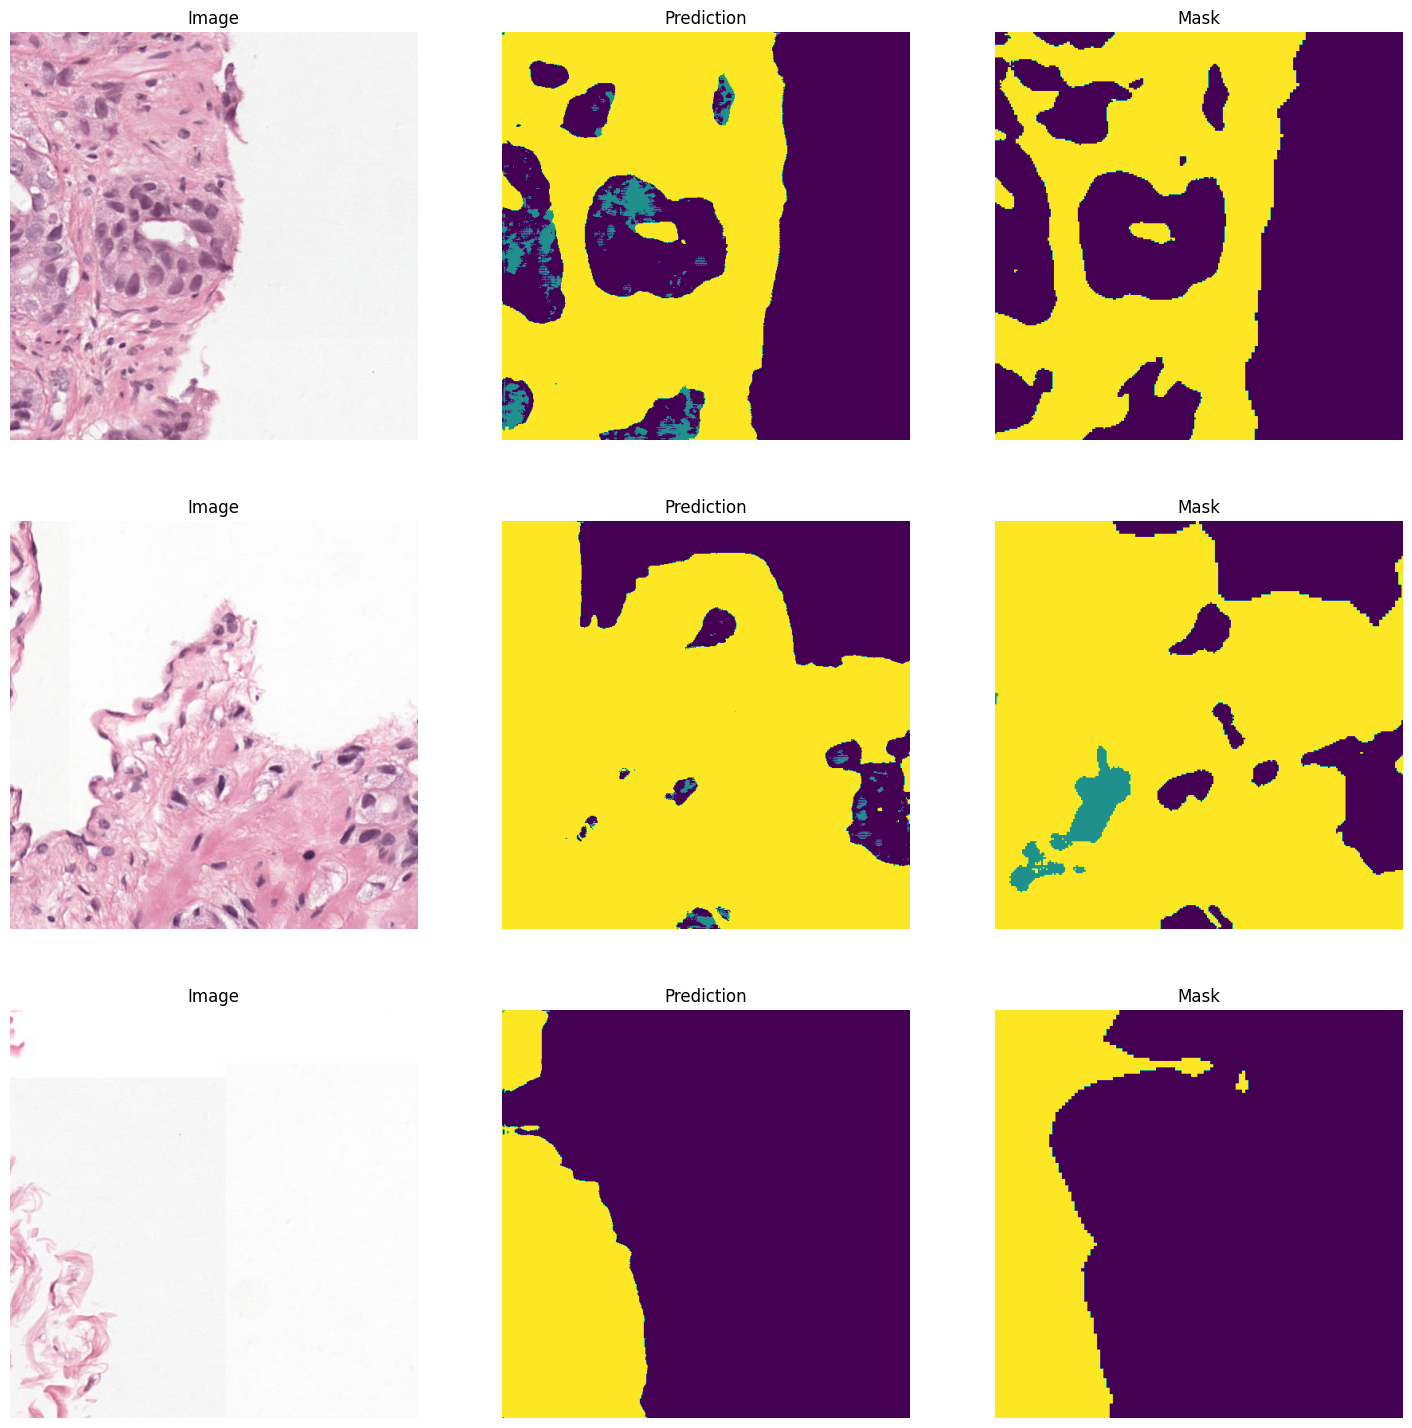

In [ ]:
for x,y in test_batch:
    x = x.to(DEVICE)
    fig , ax =  plt.subplots(3, 3, figsize=(18, 18))
    softmax = nn.Softmax(dim=1)
    preds = torch.argmax(softmax(model(x.float())),axis=1).to('cpu')
    img1 = np.transpose(np.array(x[0,:,:,:].to('cpu')),(1,2,0))
    preds1 = np.array(preds[0,:,:])
    mask1 = np.array(y[0,:,:])
    img2 = np.transpose(np.array(x[1,:,:,:].to('cpu')),(1,2,0))
    preds2 = np.array(preds[1,:,:])
    mask2 = np.array(y[1,:,:])
    img3 = np.transpose(np.array(x[2,:,:,:].to('cpu')),(1,2,0))
    preds3 = np.array(preds[2,:,:])
    mask3 = np.array(y[2,:,:])
    ax[0,0].set_title('Image')
    ax[0,1].set_title('Prediction')
    ax[0,2].set_title('Mask')
    ax[1,0].set_title('Image')
    ax[1,1].set_title('Prediction')
    ax[1,2].set_title('Mask')
    ax[2,0].set_title('Image')
    ax[2,1].set_title('Prediction')
    ax[2,2].set_title('Mask')
    ax[0][0].axis("off")
    ax[1][0].axis("off")
    ax[2][0].axis("off")
    ax[0][1].axis("off")
    ax[1][1].axis("off")
    ax[2][1].axis("off")
    ax[0][2].axis("off")
    ax[1][2].axis("off")
    ax[2][2].axis("off")
    ax[0][0].imshow(img1)
    ax[0][1].imshow(preds1)
    ax[0][2].imshow(mask1)
    ax[1][0].imshow(img2)
    ax[1][1].imshow(preds2)
    ax[1][2].imshow(mask2)
    ax[2][0].imshow(img3)
    ax[2][1].imshow(preds3)
    ax[2][2].imshow(mask3)   
    break

In [9]:
#model = torch.load("/content/drive/MyDrive/biopseModel.pth")
model = unet_model().to(DEVICE)
model=torch.load("/content/drive/MyDrive/biopseModel.pth", map_location=DEVICE)

model.eval()

unet_model(
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv1): encoding_block(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): encoding_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

In [33]:
def image_loader(image_name):
 
    image = Image.open(image_name)
    image = np.array(Image.open(image_name))
    image=image/255.0
    image = t1(image=image)["image"]
    image = image.unsqueeze(0) 
    return image

In [43]:
softmax = nn.Softmax(dim=1)
x=image_loader("/content/drive/MyDrive/BiopseDataValidation/images/patch_125.png")
prediction = torch.argmax(softmax(model(x.float())),axis=1).to('cpu')



In [44]:
prediction

tensor([[[2, 1, 1,  ..., 2, 1, 2],
         [2, 2, 1,  ..., 2, 2, 2],
         [2, 1, 1,  ..., 2, 2, 2],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]])